### Capstone Project
###  Steps:
#### 1 - Raggruppare i job titles in categorie. Es UX Designer, Graphic Designer, Senior Designer ---> 'Designer'
#### 2 - Convertire la job description in features. es one hot encoding of words used; magari poi seguito da word2vec.
#### 3 - Train in modello, validandolo con cross-validation
#### 4 - Piccola Flask API per offrire il modello al pubblico.

In [1]:
import nltk
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
import pandas as pd
from pandas.compat import StringIO
from wordcloud import WordCloud

import string 
import re
from gensim.models import Word2Vec

from nltk.tokenize import RegexpTokenizer

from nltk.tokenize import word_tokenize
from nltk import ne_chunk_sents
from nltk.tokenize import sent_tokenize
from nltk import pos_tag
from wordcloud import WordCloud
pd.option_context('display.max_colwidth', 250)

In [2]:
data = pd.read_csv('job_skills.csv')

### Google jobs dataset : a bit of EDA! 

In [3]:
data.columns

Index(['Company', 'Title', 'Category', 'Location', 'Responsibilities',
       'Minimum Qualifications', 'Preferred Qualifications'],
      dtype='object')

In [4]:
data.shape

(1250, 7)

In [5]:
# after dropping NaNs there are 20 rows less in the dataset
data = data.dropna()
data.shape

(1235, 7)

#### A barplot diagram of the most important positions in the dataset

In [6]:
titles = data['Title'].value_counts()

In [7]:
# take top ten
print(len(titles))
titles = titles[0:20]

779


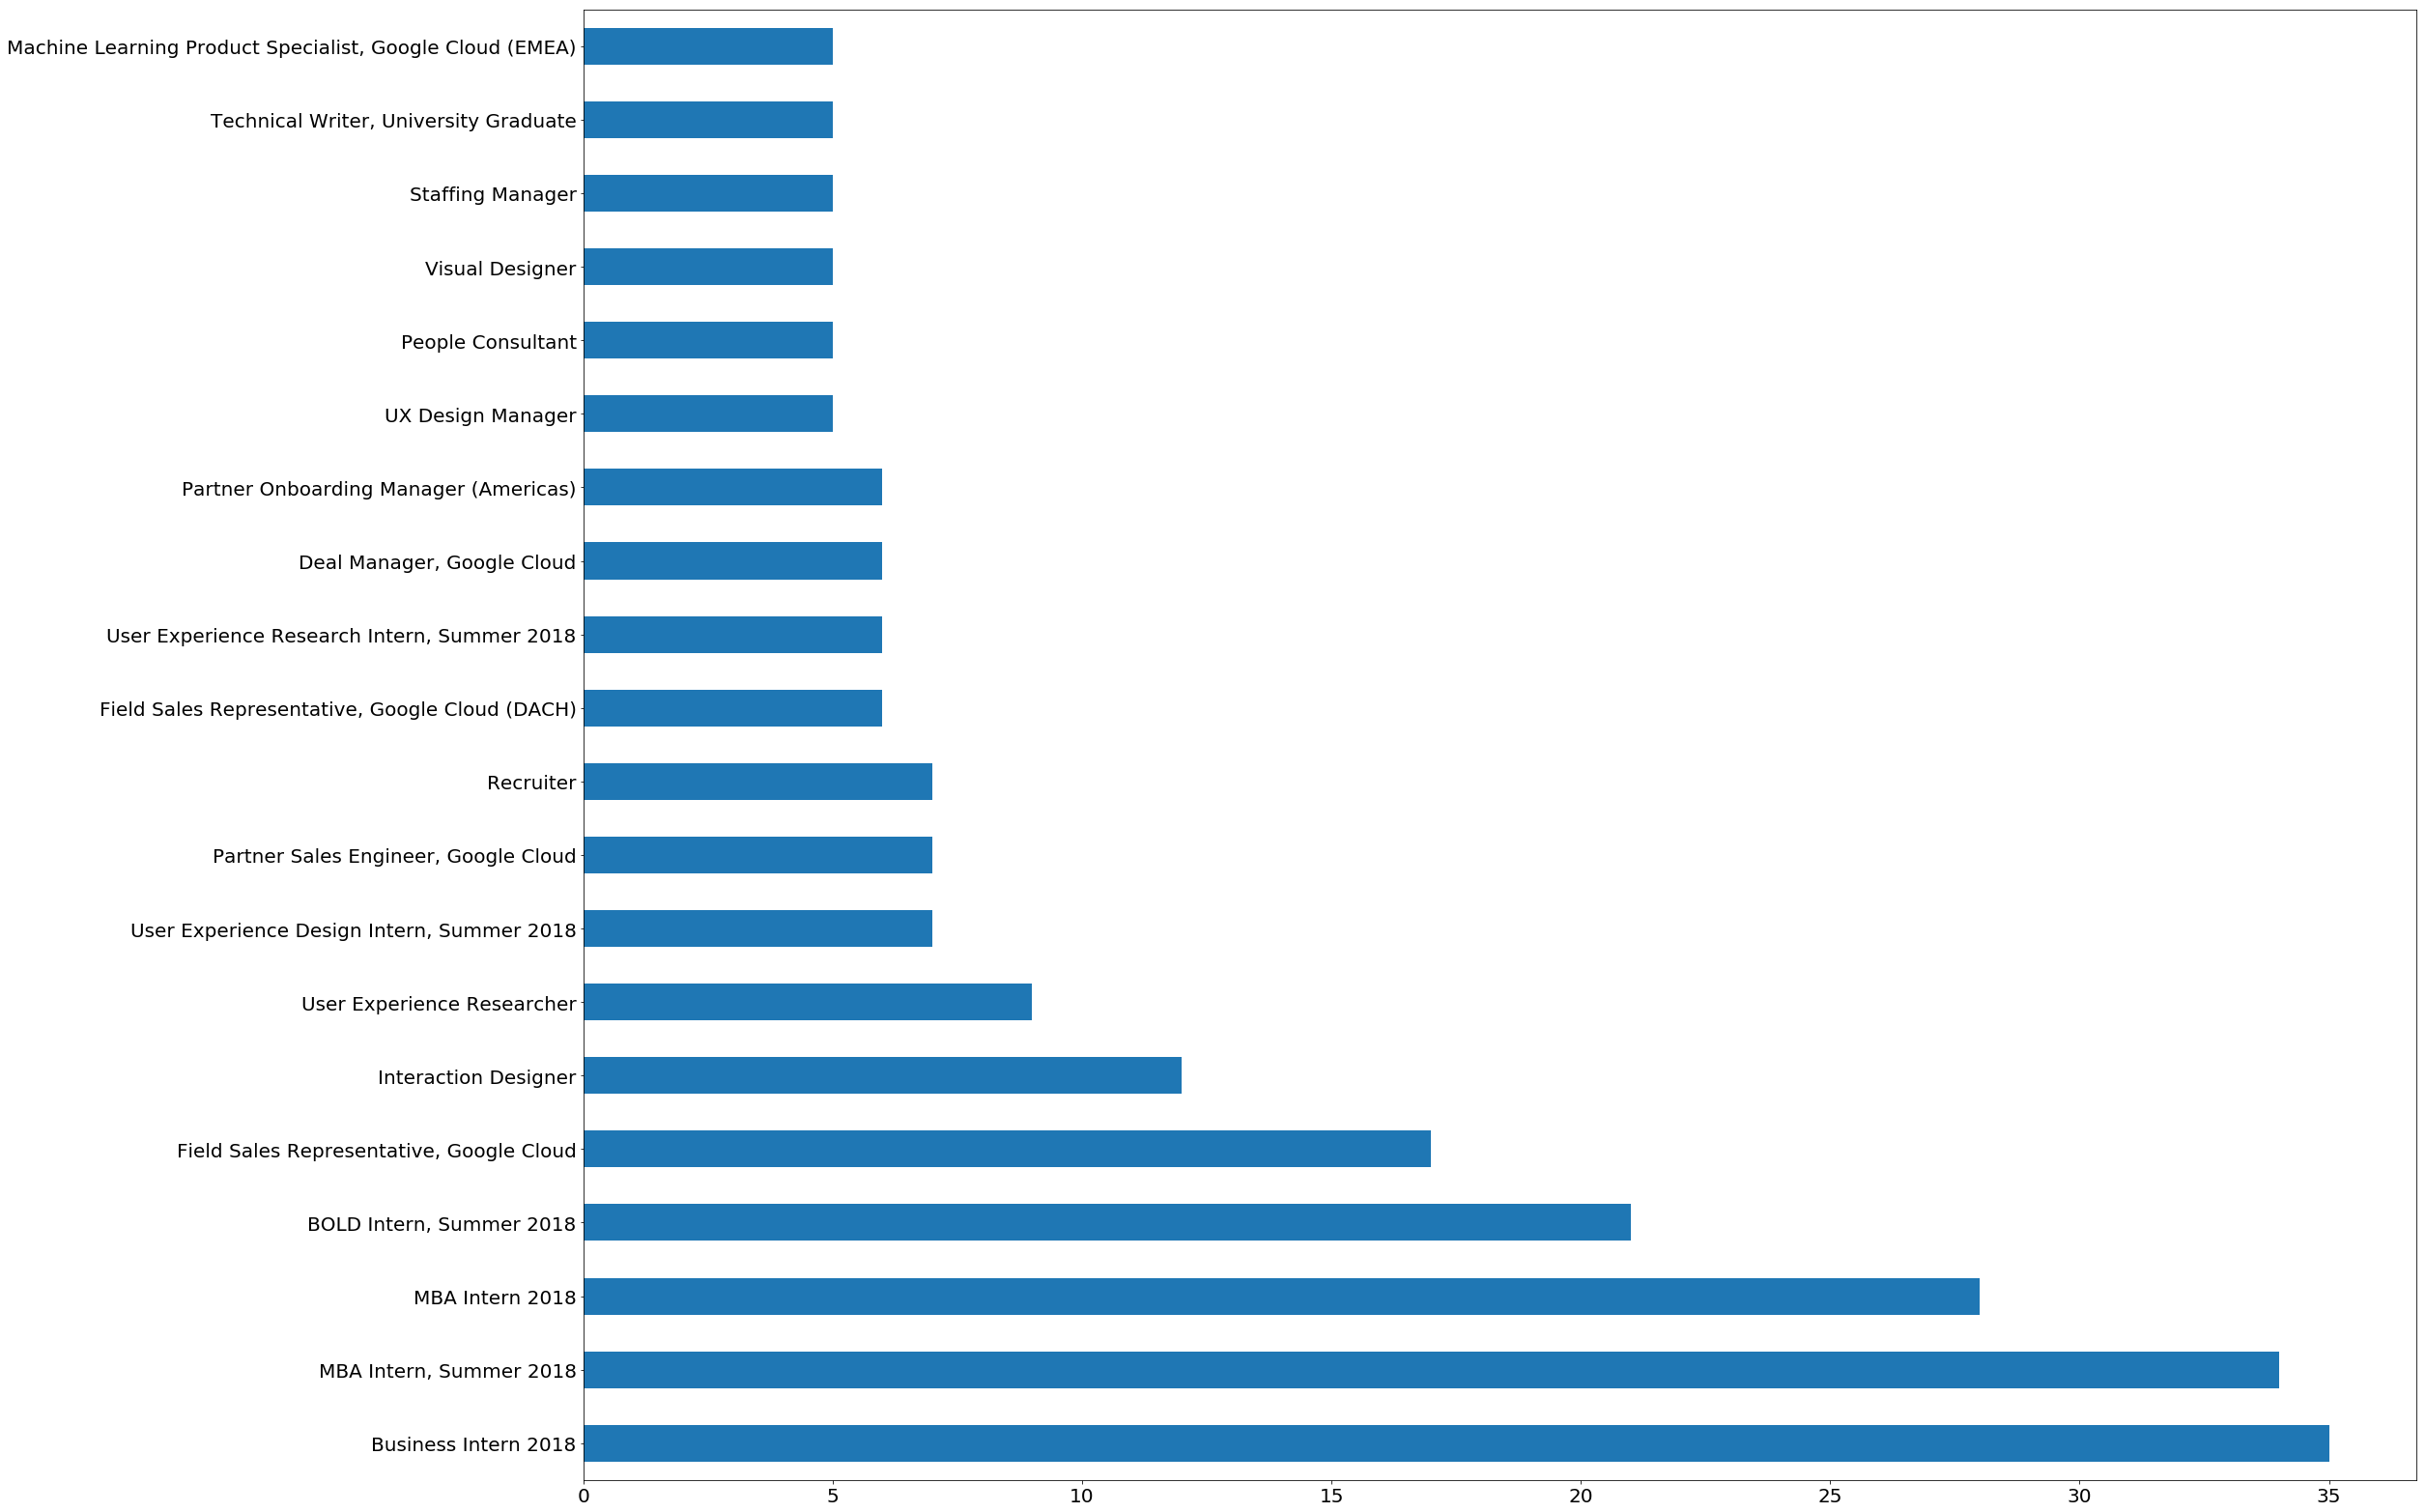

In [8]:
plt.subplots(figsize=(34,28))
p = titles.plot('barh')
p.tick_params(labelsize=20)

#### A barplot diagrma of Category and Location field

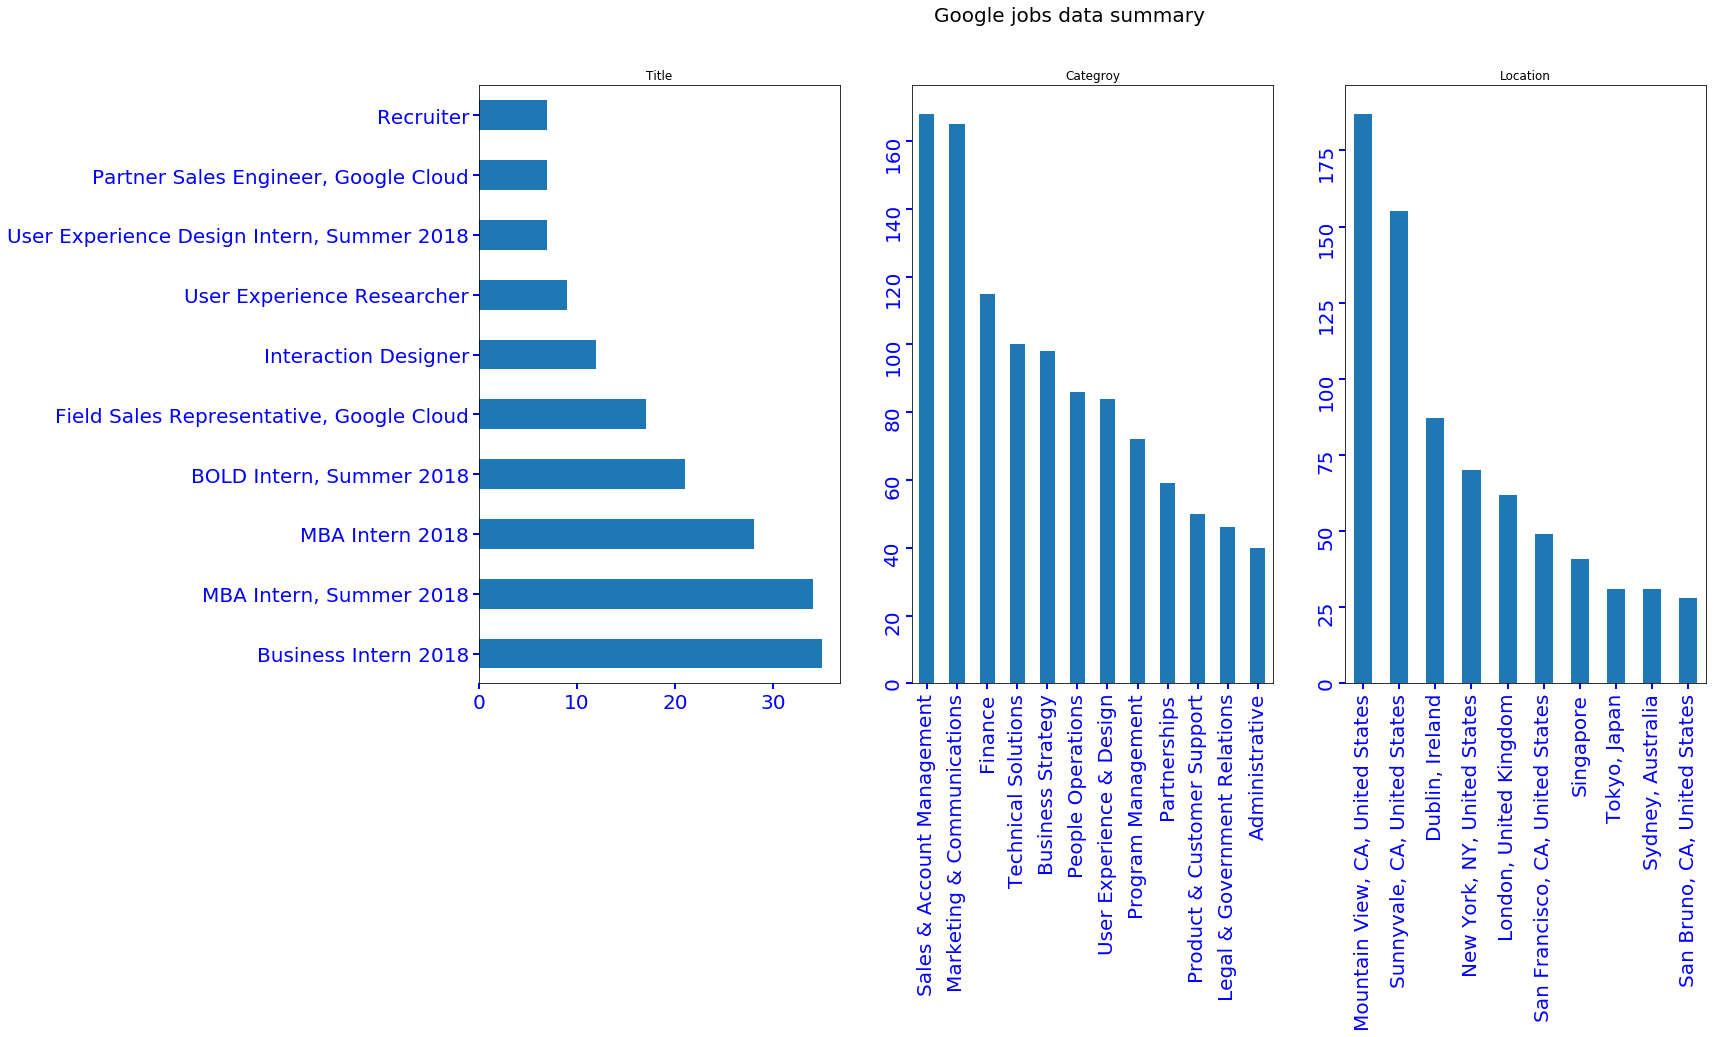

In [9]:
fig, ax_array = plt.subplots(1, 3, figsize=(22,11))
(ax1, ax2, ax3) = ax_array
fig.suptitle('Google jobs data summary ', size=20)


titles = data['Title'].value_counts().head(10)
titles.plot(kind='barh', ax=ax1, title='Title')
ax1.tick_params(direction='out', length=6, width=2, colors='b',labelsize= 20,
               grid_color='r', grid_alpha=0.5)

cat = data['Category'].value_counts().head(12)
cat.plot(kind='bar', ax=ax2, rot=1, title='Categroy')
ax2.tick_params(direction='out', length=6, width=2, colors='b',labelsize= 20, labelrotation= 90,
               grid_color='r', grid_alpha=0.5)

loc = data['Location'].value_counts().head(10)
loc.plot(kind='bar', ax=ax3, rot=1, title='Location')
ax3.tick_params(direction='out', length=6, width=2, colors='b',labelsize= 20, labelrotation= 90,
               grid_color='r', grid_alpha=0.5)


#### There are 20 categories in total. 

In [10]:
cat = data['Category'].value_counts()
cat

Sales & Account Management          168
Marketing & Communications          165
Finance                             115
Technical Solutions                 100
Business Strategy                    98
People Operations                    86
User Experience & Design             84
Program Management                   72
Partnerships                         59
Product & Customer Support           50
Legal & Government Relations         46
Administrative                       40
Sales Operations                     31
Real Estate & Workplace Services     25
Software Engineering                 24
Hardware Engineering                 22
Manufacturing & Supply Chain         16
Technical Infrastructure             11
Network Engineering                   6
Developer Relations                   5
IT & Data Management                  5
Technical Writing                     5
Data Center & Network                 2
Name: Category, dtype: int64

#### Here I'm encoding the first ten most large categories while considering the remaining categories which are less important as a unique category.


In [11]:
my_category= []

for i in data['Category']:
    if 'Sales & Account Management' in i:
        my_category.append(0)
        continue
        
    if 'Marketing & Communications' in i :
        my_category.append(1)
        continue
        
    if 'Finance' in i :
        my_category.append(2)
        continue
        
    if 'Technical Solutions' in i :
        my_category.append(3)  
        continue
        
    if 'Business Strategy' in i :
        my_category.append(4) 
        continue
        
    if 'People Operations' in i:
        my_category.append(5)
        continue
        
    if 'User Experience & Design' in i:
        my_category.append(6)
        continue
        
    if 'Program Management' in i:
        my_category.append(7)
        continue
        
    if 'Partnerships' in i:
        my_category.append(8)
        continue
        
    if 'Product & Customer Support' in i:
        my_category.append(9)
    else:
        my_category.append(10)

In [12]:
# add the column 'My_category' as a label to the dataste
data.insert(loc=7, column='My_category', value=my_category)

#### Validation of categories with wordcloud graphics

In [13]:
data_sales = data.loc[data['Category'] == 'Sales & Account Management']
data_marketing = data.loc[data['Category'] == 'Marketing & Communications']
data_design = data.loc[data['Category'] == 'People Operations']
data_operations = data.loc[data['Category'] == 'User Experience & Design']

In [14]:
# Initialize the new lists that will contain text without stop words
words_marketing = []
words_sales = []
words_design = []
words_operations = []
words_marketing = data_marketing['Responsibilities'].tolist()
words_sales = data_sales['Responsibilities'].tolist()
words_design = data_design['Responsibilities'].tolist()
words_operations = data_operations['Responsibilities'].tolist()

In [15]:
str_words_marketing = ''.join(str(e) for e in words_marketing)
str_words_sales = ''.join(str(e) for e in words_sales)
str_words_design = ''.join(str(e) for e in words_design)
str_words_operations = ''.join(str(e) for e in words_operations)

In [16]:
tokenizer = RegexpTokenizer('\w+')
tokens_sales = tokenizer.tokenize(str_words_sales.lower())
tokens_marketing = tokenizer.tokenize(str_words_marketing.lower())
tokens_design = tokenizer.tokenize(str_words_design.lower())
tokens_operations = tokenizer.tokenize(str_words_operations.lower())


In [17]:
sw = nltk.corpus.stopwords.words('english')
sales = []
marketing = []
design = []
operations = []

for word in tokens_sales: 
    sales.append(word)
    
for word in tokens_marketing: 
    marketing.append(word) 
    
for word in tokens_design: 
    design.append(word)    
    
for word in tokens_operations: 
    operations.append(word)    

In [18]:
# Initialize new list that will contain text without stop words
sales_ns = []
marketing_ns = []
design_ns = []
op_ns = []
# Add to words_ns all words that are in words but not in sw
for word in sales:
    if word not in sw:
        sales_ns.append(word)

for word in marketing:
    if word not in sw:
        marketing_ns.append(word)

for word in design:
    if word not in sw:
        design_ns.append(word)

for word in operations:
    if word not in sw:
        op_ns.append(word)        
        

In [19]:
freqdist_marketing = nltk.FreqDist(marketing_ns)
freqdist_sales = nltk.FreqDist(sales_ns)
freqdist_operations = nltk.FreqDist(op_ns)
freqdist_design = nltk.FreqDist(design_ns)

#### Following four wordcloud graphics of sales, marketing, operations and design

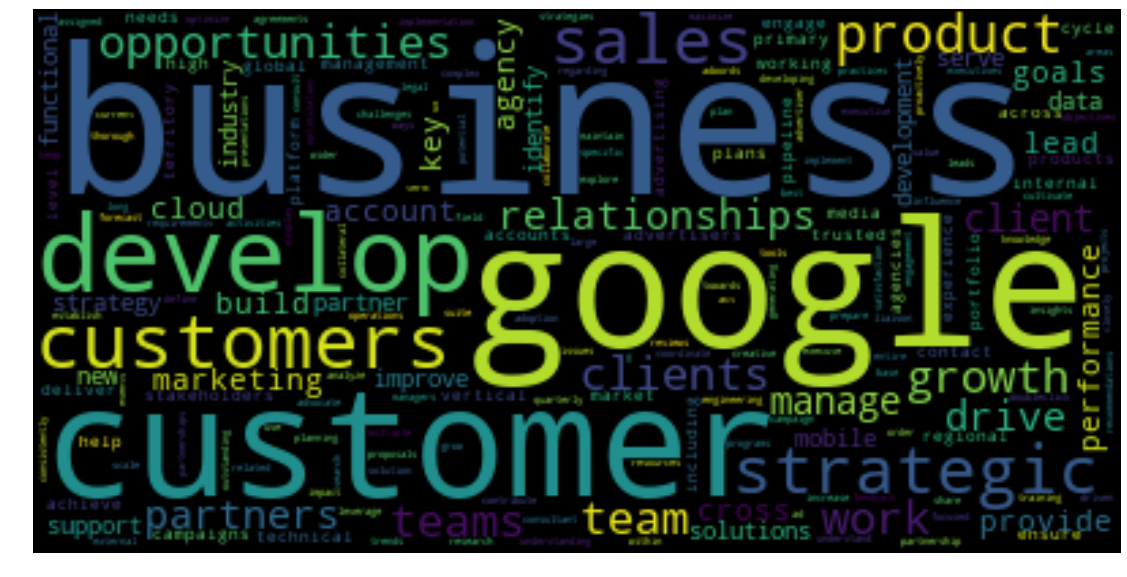

In [20]:
# here I add a word cloud graphics which shows the most common words
wcloud = WordCloud().generate_from_frequencies(freqdist_sales)
plt.figure(figsize=(20,10))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

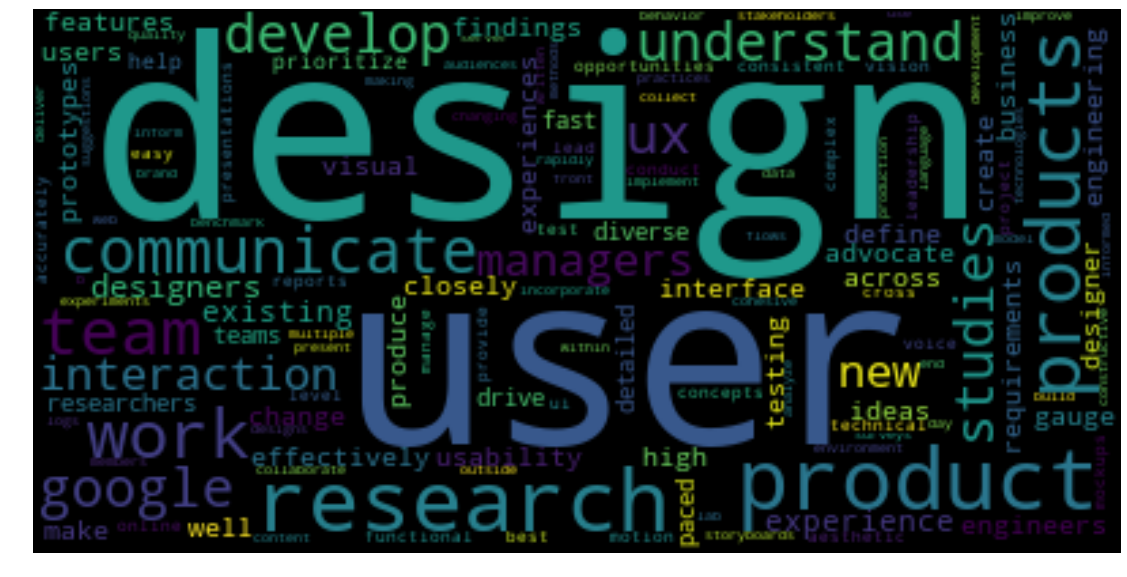

In [21]:
# here I add a word cloud graphics which shows the most common words
wcloud = WordCloud().generate_from_frequencies(freqdist_operations)
plt.figure(figsize=(20,10))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

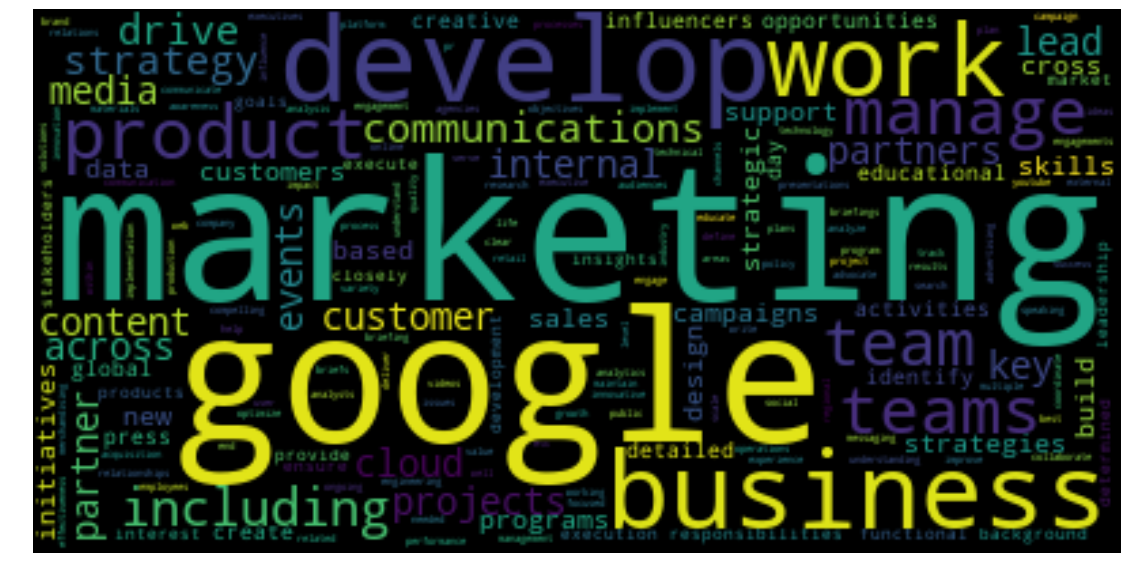

In [22]:
# here I add a word cloud graphics which shows the most common words
wcloud = WordCloud().generate_from_frequencies(freqdist_marketing)
plt.figure(figsize=(20,10))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

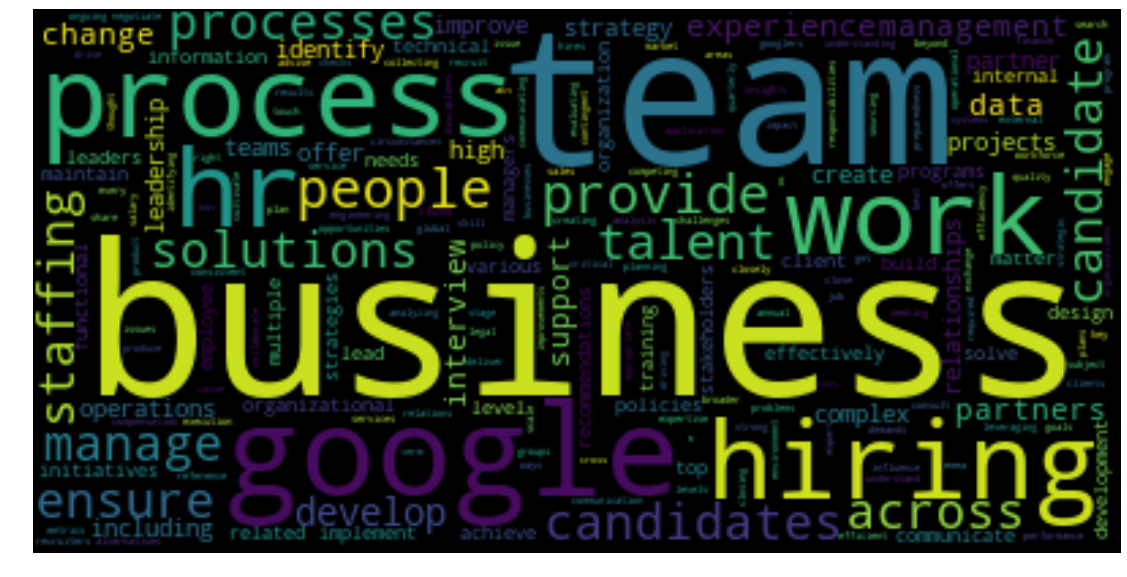

In [23]:
# here I add a word cloud graphics which shows the most common words
wcloud = WordCloud().generate_from_frequencies(freqdist_design)
plt.figure(figsize=(20,10))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

#### First encoding of the features : a Word2Vec model using Gensim

In [24]:
tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def clean_txt(tex):
    tex_no_pun ="".join([char for char in tex if char not in string.punctuation])
    tokens = re.split('\W+', tex_no_pun)
    tex_no_pun = [ps.stem(word) for word in tokens if word not in stopwords]
    return tex_no_pun

sentences = []
for i in data['Responsibilities']:
    li = clean_txt(i)
    sentences.append(li)

In [25]:
# model
model = Word2Vec(sentences, min_count=1)
# summarize model
print(model)

Word2Vec(vocab=2775, size=100, alpha=0.025)


In [26]:
# words in vocabulary
words = list(model.wv.vocab) 
print(len(words))

2775


In [27]:
# print vector for one word 
print(model['design'])

[ 0.02244033 -0.90049005  0.26814675 -0.8859139   0.18175343 -0.673314
 -0.17189136  0.42339042 -0.4083371  -0.28605717 -0.25480154 -0.0925888
 -0.10122688  0.20662667  0.741671   -0.38919753  0.03096228  0.68969107
  0.646885    0.16033329 -0.03980658  0.37846395 -0.2695202  -0.3070626
 -0.17912652 -0.01642931 -0.769603    0.43082696  0.23126398 -0.21147852
 -0.08435621  0.2020651   0.8416163   0.0448659  -0.38398087 -0.083399
 -0.12668875 -0.02475612 -0.22157067  0.48939496 -0.24103913  0.14066488
 -0.6580585  -0.39136112 -0.42206082 -0.2261744  -0.27937344  0.08689705
 -0.6679556  -0.06829698  0.51654166  0.2790546   0.10793665  0.41649237
 -0.39355448 -0.93281245  0.35449427  0.05624882 -0.12556197  0.43744332
  0.37814915 -0.04635462  0.1140824  -0.00513745 -0.0729925  -0.48721212
  0.17295735  0.19590443  0.78154737 -0.132376    0.44594166 -0.49942362
 -0.33378354  0.59974515 -0.01119055  0.44441777 -0.14283875  0.33897448
  0.05474294  0.14097531  0.24611343 -0.00630277  0.00705

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


#### Second encoding of the features :  using a Tf-IDF vectorizer 

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidf_vect = TfidfVectorizer(analyzer=clean_txt)

In [30]:
X_tfidf = tfidf_vect.fit_transform(data['Responsibilities'])
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(1235, 2775)
['', '10q10k', '10x', '11', '1tomani', '20', '247', '24x7', '2D', '2d3d', '30', '3D', '3plasp', '3pr', '40', '50', 'AB', 'AM', 'AR', 'AV', 'Ad', 'As', 'BD', 'BI', 'Be', 'C', 'CA', 'CC', 'CE', 'CM', 'CX', 'DC', 'EU', 'FA', 'FX', 'G', 'Go', 'HR', 'IA', 'IC', 'IN', 'IP', 'IT', 'If', 'In', 'MA', 'ML', 'OS', 'PA', 'PD', 'PM', 'PR', 'QA', 'SP', 'TV', 'UI', 'UK', 'UL', 'US', 'UX', 'VP', 'VR', 'abil', 'abl', 'abreast', 'abroad', 'absenc', 'abstract', 'abus', 'abusespam', 'academia', 'acceler', 'accept', 'acceptancedeclin', 'access', 'accessori', 'accommod', 'accommodationsaccess', 'accomplish', 'accord', 'accordingli', 'account', 'accountterritori', 'accrual', 'accur', 'accuraci', 'accuratetlmfunct', 'achiev', 'achiv', 'acquir', 'acquisit', 'across', 'act', 'action', 'actionsimprov', 'activ', 'actual', 'acumen', 'ad', 'adapt', 'add', 'addit', 'address', 'adequ', 'adher', 'adhoc', 'adjust', 'administ', 'administr', 'admiss', 'admob', 'adopt', 'adoptionrel', 'adoptionusag', 'adsens'

In [31]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())

In [32]:
X_tfidf_df.columns = tfidf_vect.get_feature_names()
#X_tfidf_df.iloc[100:300, 200:400]

#### After deciding to use TF-IDF as a method of encoding, I use a RandomForestClassifier for the classification

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
#here I check methods and args of the RandomForestClassifier class
#print(RandomForestClassifier())
#print(dir(RandomForestClassifier()))

In [35]:
from sklearn.model_selection import KFold, cross_val_score

#### Here I use a 5-fold validation printing out the accuracy of each combination of training set - test set.

In [36]:
rf = RandomForestClassifier(n_jobs = -1)
kfold = KFold(n_splits=10)
cross_val_score(rf, X_tfidf_df, data['My_category'], cv = kfold, scoring = 'accuracy', n_jobs = -1)

array([0.68548387, 0.62903226, 0.79032258, 0.64516129, 0.73387097,
       0.69918699, 0.23577236, 0.47154472, 0.60162602, 0.51219512])

In [37]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

#### Finally I select the train and test set (80-20) by using the train_test_split() method

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_df, data['My_category'], test_size= 0.2)

#### Here I instantiate a RF classier and fit the model i.e. make the training of the model using the training data 

In [77]:
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs = -1)

In [78]:
rf_model = rf.fit(X_train, y_train)

#### Here to have an idea the most important features using feature_importances_

In [79]:
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse = True)[0:20]

[(0.013805946968634948, 'opportun'),
 (0.011880418501541147, 'respons'),
 (0.010932193947417547, 'technic'),
 (0.009946376498551372, 'partner'),
 (0.009567294273383228, 'intern'),
 (0.009504592986635495, 'custom'),
 (0.009465937574432964, 'meaning'),
 (0.009018710155302144, 'solut'),
 (0.008644581170471198, 'lot'),
 (0.008618281990713855, 'educ'),
 (0.0086020007913704, 'candid'),
 (0.008547273114614336, 'market'),
 (0.008513816110508438, 'develop'),
 (0.008348317593536932, 'account'),
 (0.007990646166728822, 'client'),
 (0.00784098316544871, 'start'),
 (0.007629187361952412, 'financi'),
 (0.007428313581260983, 'user'),
 (0.007385028966125068, 'contribut'),
 (0.0073427538691213145, 'team')]

#### Here I make the predictions on the test set

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
y_pred

In [ ]:
precision, recall, fscore, support = score(y_test, y_pred)

In [ ]:
precision

In [ ]:
recall

In [ ]:
fscore

In [ ]:
print('accuracy')
print(round( (y_pred==y_test).sum()/len(y_pred),3))

#### Here I perform a grid search by varying the parameters of the model 

In [ ]:
def train_RF(n_est, depth):
    rf = RandomForestClassifier(n_estimators = n_est, max_depth = depth, n_jobs = -1)
    rf_model = rf.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    precision,recall,fscore,support = score(y_test, y_pred)
    print('Est:{} / Depth: {} / Precision :{} / Recall : {} / Fscore : {} / Accuracy: {} '.format(
          n_est, depth, precision[0], recall[0], fscore[0], round((y_pred == y_test).sum() / len(y_pred) , 3)
          )) 

#### In the next window of code only precision and recall for the first label is printed.

In [ ]:
for n_est in [10,30, 50, 100]:
    for depth in [10,30, 50, 150, None]:
        train_RF(n_est, depth)
    print('---------------------------------------------------') 